In [1]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
from train_model import train_model
from test_model import test_model
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='3'

In [3]:
filePath = '/local/rcs/ll3504/datasets/256_ObjectCategories/'
namelist = os.listdir(filePath)
nameDic_cal = {}
for name in namelist:
    splits = name.split(".")
    nameDic_cal[int(splits[0])-1] = splits[1]
print(nameDic_cal[1])

american-flag


In [4]:
import re
fileName = '/local/rcs/ll3504/datasets/tiny-imagenet-200/words.txt'
nameDic_tiny = {}
with open(fileName, "r") as f:
    temp = f.readlines()
for i in range(len(temp)):
    splits = re.split(',|\n|\t', temp[i])
    nameDic_tiny[splits[0]] = splits[1]

In [5]:
filePath = '/local/rcs/ll3504/datasets/tiny-224/train/'
namelist = os.listdir(filePath)
namelist.sort()
nameDic_t = {}
i = 0
for name in namelist:
    if name.startswith('n'):
        nameDic_t[i] = name
        i += 1

In [6]:
nameDic_tiny_imageNet = {}
for key in nameDic_t:
    nameDic_tiny_imageNet[key] = nameDic_tiny[nameDic_t[key]]

In [7]:
common_classes = []
i = 0
for key in nameDic_tiny_imageNet:
    if nameDic_tiny_imageNet[key] in nameDic_cal.values():
        temp = str(i)+" "+str(nameDic_tiny_imageNet[key])
        common_classes.append(str(temp))
        i += 1
print(common_classes)

['0 goldfish', '1 centipede', '2 goose', '3 snail', '4 grasshopper', '5 cockroach', '6 backpack', '7 bathtub', '8 binoculars', '9 cannon', '10 hourglass', '11 refrigerator', '12 syringe', '13 teapot', '14 mushroom']


In [8]:
with open("common_classes_tinyImageNet_Caltech256.txt","w") as f:
    for common_class in common_classes:
        f.write(common_class+"\n")

In [9]:
import re
fileName = 'common_classes_tinyImageNet_Caltech256.txt'
common_classes = {}
with open(fileName, "r") as f:
    temp = f.readlines()
print(temp)
for i in range(len(temp)):
    splits = temp[i].split()
    common_classes[splits[1]] = int(splits[0])
print(common_classes)

['0 goldfish\n', '1 centipede\n', '2 goose\n', '3 snail\n', '4 grasshopper\n', '5 cockroach\n', '6 backpack\n', '7 bathtub\n', '8 binoculars\n', '9 cannon\n', '10 hourglass\n', '11 refrigerator\n', '12 syringe\n', '13 teapot\n', '14 mushroom\n']
{'goldfish': 0, 'centipede': 1, 'goose': 2, 'snail': 3, 'grasshopper': 4, 'cockroach': 5, 'backpack': 6, 'bathtub': 7, 'binoculars': 8, 'cannon': 9, 'hourglass': 10, 'refrigerator': 11, 'syringe': 12, 'teapot': 13, 'mushroom': 14}


In [10]:
data_dir = '/local/rcs/ll3504/datasets/tiny-224-common/'
num_workers = {'train' : 100,'val'   : 100,'test'  : 100}
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.RandomCrop(224),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val','test']}
tiny_dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
                  for x in ['train', 'val', 'test']}
tiny_dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

/home/ll3504/anaconda3/envs/edgemonitor/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 80, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
        ]),
        'test': transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])
    print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
    print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset

In [4]:
def split_dataset(train_dataset, test_dataset, valid_size=0.2):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torchdata.DataLoader(train_dataset, batch_size=30, shuffle=False, num_workers=30, pin_memory=True, drop_last=True, sampler = train_sampler)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=30, shuffle=False, num_workers=30, pin_memory=True, drop_last=True, sampler = valid_sampler)
    dataloaders = {'train': train_loader,
                   'val': test_loader,
                   'test': test_loader}
    dataset_sizes ={'train': int(np.floor((1-valid_size) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [5]:
imagebase = '/local/rcs/ll3504/datasets/'

In [6]:
pascal_train_images, pascal_test_images = get_dataset(imagebase, 'image_CLEF/pascal')
pascal_dataloaders, pascal_dataset_sizes = split_dataset(pascal_train_images, pascal_test_images, 0.2)

image_CLEF/pascal train set size: 600
image_CLEF/pascal test set size: 600


In [7]:
bing_train_images, bing_test_images = get_dataset(imagebase, 'image_CLEF/bing')
bing_dataloaders, bing_dataset_sizes = split_dataset(bing_train_images, bing_test_images, 0.2)

image_CLEF/bing train set size: 600
image_CLEF/bing test set size: 600


In [8]:
imagenet_train_images, imagenet_test_images = get_dataset(imagebase, 'image_CLEF/imagenet')
imagenet_dataloaders, imagenet_dataset_sizes = split_dataset(imagenet_train_images, imagenet_test_images, 0.2)

image_CLEF/imagenet train set size: 600
image_CLEF/imagenet test set size: 600


In [9]:
caltech_train_images, caltech_test_images = get_dataset(imagebase, 'image_CLEF/caltech')
caltech_dataloaders, caltech_dataset_sizes = split_dataset(caltech_train_images, caltech_test_images, 0.2)

image_CLEF/caltech train set size: 600
image_CLEF/caltech test set size: 600


In [10]:
#Load Resnet50
model_ft = models.resnet50(True)
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc.out_features = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Epoch 1/10
----------
Iteration: 6/6, Loss: 27.050471305847168...Train Loss: 5.4477 Acc: 0.2833
Val Loss: 1.5758 Acc: 0.6833

Epoch 2/10
----------
Iteration: 6/6, Loss: 16.52523636817932.3..Train Loss: 0.5290 Acc: 0.8708
Val Loss: 0.4206 Acc: 0.9000

Epoch 3/10
----------
Iteration: 6/6, Loss: 5.722718238830566....Train Loss: 0.1771 Acc: 0.9562
Val Loss: 0.3222 Acc: 0.8917

Epoch 4/10
----------
Iteration: 6/6, Loss: 1.1383932828903198.3..Train Loss: 0.1088 Acc: 0.9688
Val Loss: 0.2927 Acc: 0.9083

Epoch 5/10
----------
Iteration: 6/6, Loss: 17.556192874908447.87.Train Loss: 0.0744 Acc: 0.9771
Val Loss: 0.3076 Acc: 0.9167

Epoch 6/10
----------
Iteration: 6/6, Loss: 1.0497337579727173.3..Train Loss: 0.0483 Acc: 0.9938
Val Loss: 0.3263 Acc: 0.9250

Epoch 7/10
----------
Iteration: 6/6, Loss: 10.00020146369934..4..Train Loss: 0.0360 Acc: 0.9938
Val Loss: 0.3261 Acc: 0.9167

Epoch 8/10
----------
Iteration: 6/6, Loss: 5.786183476448059.3.2.Train Loss: 0.0210 Acc: 1.0000
Val Loss: 0.3050 

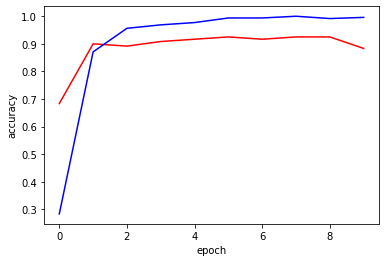

Training complete in 1m 3s
Best Validation Accuracy: 0.9249999999999999, Epoch: 6


In [50]:
#Train
train_model("imageclef-caltech-224", model_ft, caltech_dataloaders, caltech_dataset_sizes, criterion, optimizer_ft, num_epochs=10)

In [51]:
# model_ft.load_state_dict(torch.load('./models/model_6_epoch.pt'))
# #Test
# test_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft)

### Evaluate models

In [47]:
#Test Resnet50-224
model = models.resnet50()
#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc.out_features = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('models/imageclef-imagenet-224/model_6_epoch.pt'))
model = model.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [61]:
#Test
test_model(model, pascal_dataloaders, pascal_dataset_sizes, criterion, optimizer)

Iteration: 4/4, Loss: 91.25153303146362..
Test Loss: 1.7168 Acc: 0.6417

Test complete in 0m 3s


In [62]:
test_model(model, imagenet_dataloaders, imagenet_dataset_sizes, criterion, optimizer)

Iteration: 4/4, Loss: 1.7629026621580124.
Test Loss: 0.1412 Acc: 0.9500

Test complete in 0m 3s


In [63]:
test_model(model, bing_dataloaders, bing_dataset_sizes, criterion, optimizer)

Iteration: 4/4, Loss: 76.30678653717041.
Test Loss: 2.4123 Acc: 0.4667

Test complete in 0m 3s


In [64]:
test_model(model, caltech_dataloaders, caltech_dataset_sizes, criterion, optimizer)

Iteration: 4/4, Loss: 21.075206995010376.
Test Loss: 0.7263 Acc: 0.7917

Test complete in 0m 2s


### Drift Detection

In [11]:
from utils.drift_detection import drift_detection
from utils.k_means import kmeans
from timeit import default_timer as timer
from sklearn.decomposition import PCA
from scipy.stats import entropy
from scipy.special import softmax
from scipy.stats import chi2_contingency, ks_2samp, entropy
import torch

In [12]:
def get_result(model, dataloaders):
    data = []
    labels = []
    uncertainties = []
    accuracys = []
    for x, label in dataloaders['val']:
        x = x.cuda()
        label = label.cuda()
        x = model(x)
        _, predicted = torch.max(x, 1)
        x = x.cpu().detach().numpy()
        uncertainty = entropy(softmax(x, axis=-1), axis=-1)
        size = label.shape[0]
        correct = (predicted == label).sum().item()
        accuracy = correct/size
        data.append(x)
        labels.append(label)
        uncertainties.append(uncertainty)
        accuracys.append(accuracy)
    return data, labels, uncertainties, accuracys

In [14]:
def process_data(data, labels):
    new_data = []
    new_labels = []
    for batch in data:
        for i in batch:
            new_data.append(i)
    for batch in labels:
        for i in batch:
            new_labels.append(i)
    return new_data, new_labels

In [48]:
i_x, i_y, i_uncertainties, i_acc = get_result(model, imagenet_dataloaders)
i_x_processed, i_y_processed = process_data(i_x, i_y)

In [49]:
b_x, b_y, b_uncertainties, b_acc = get_result(model, bing_dataloaders)
b_x_processed, b_y_processed = process_data(b_x, b_y)

In [50]:
p_x, p_y, p_uncertainties, p_acc = get_result(model, pascal_dataloaders)
p_x_processed, p_y_processed = process_data(p_x, p_y)

In [51]:
c_x, c_y, c_uncertainties, c_acc = get_result(model, caltech_dataloaders)
c_x_processed, c_y_processed = process_data(c_x, c_y)

In [52]:
detector = drift_detection(b_x_processed,  .05, 'KSDrift')

In [ ]:
print('bing: ')
preds = detector.get_result(b_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

In [ ]:
print('imagenet: ')
preds = detector.get_result(i_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

In [ ]:
print('pascal: ')
preds = detector.get_result(p_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

In [ ]:
print('caltech: ')
preds = detector.get_result(c_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

### Clustering

In [19]:
def print_result(uncertainties, accuracys, labels):
    clusters = {}
    for i in range(len(labels)):
        if labels[i] not in clusters:
            clusters[labels[i]] = [i]
        else:
            clusters[labels[i]].append(i)
    for cluster in clusters:
        print(f'Cluster {cluster}: ')
        total_acc = 0
        total_uncertainty = 0
        for index in clusters[cluster]:
            total_acc += accuracys[index]
            total_uncertainty += sum(uncertainties[index])/len(uncertainties[index])
        avg_acc = total_acc/len(clusters[cluster])
        avg_uncertainty = total_uncertainty/len(clusters[cluster])
        print(f'Average accuracy: {avg_acc}')
        print(f'Average uncertainty: {avg_uncertainty}')

In [20]:
def add_data(total_data):
    total_uncertainties = []
    total_accuracies = []
    for data in total_data:
        uncertainty = data[0]
        accuracy = data[1]
        for i in range(len(uncertainty)):
            total_uncertainties.append(uncertainty[i])
            total_accuracies.append(accuracy[i])
            
    return total_uncertainties, total_accuracies

In [21]:
def calculate_acc(labels, batch_size):
    accs = []
    for i in range(int(len(labels)/batch_size)):
        count = {}
        for m in range(i*batch_size, (i+1)*batch_size):
            if labels[m] not in count:
                count[labels[m]] = 1
            else:
                count[labels[m]] += 1
        max_num = -1
        max_label = -1
        for co in count:
            if count[co] > max_num:
                max_num = count[co]
                max_label = co
        count = 0
        for m in range(i*batch_size, (i+1)*batch_size):
            if labels[m] == max_label:
                count += 1
        accs.append(count/batch_size)
    return sum(accs)/len(accs)

In [53]:
total_data = [[i_uncertainties, i_acc], [b_uncertainties, b_acc], [p_uncertainties, p_acc], [c_uncertainties, c_acc]]
total_uncertainties, total_accuracies = add_data(total_data)

In [54]:
total_uncertainties = np.array(total_uncertainties)

In [58]:
labels = kmeans(total_uncertainties, 4, 500)
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [59]:
accuracy = calculate_acc(labels, 4)
print(accuracy)

1.0


In [60]:
print_result(total_uncertainties, total_accuracies, labels)

Cluster 2: 
Average accuracy: 0.7333333333333334
Average uncertainty: 0.642565000082027
